# 寻找田块的形状，找到长边进行机械化耕作
#### 因为田块的大小不尽相同，且朝向也不同，因此在规划路径的时候，需要找到一个水平于“田块长边方向”的耕作区域，这样耕作时使用的地头区域、转向次数最少

In [1]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 加载数据
all_df = gpd.read_file('shp_file/村1地_全区.shp')

In [3]:
all_df.head(1)

,NAME,LAYER,周长,闭合面积,geometry
0,地2,Unknown Area Type,315.38 m,0.001833 sq km,"POLYGON ((440418.558 4397401.724, 440417.610 4..."


In [4]:
# 将列名中的 周长、闭合面积改为英文
all_df.rename(columns={'周长': 'perimeter', '闭合面积': 'area'}, inplace=True)
all_df

,NAME,LAYER,perimeter,area,geometry
0,地2,Unknown Area Type,315.38 m,0.001833 sq km,"POLYGON ((440418.558 4397401.724, 440417.610 4..."
1,地3,Unknown Area Type,182.65 m,0.001528 sq km,"POLYGON ((440474.831 4397334.155, 440478.927 4..."
2,地4,Unknown Area Type,247.41 m,0.00125 sq km,"POLYGON ((440474.817 4397610.019, 440472.273 4..."
3,地5,Unknown Area Type,143.98 m,0.000743 sq km,"POLYGON ((440447.944 4397798.362, 440450.065 4..."
4,地6,Unknown Area Type,120.25 m,0.000631 sq km,"POLYGON ((440356.297 4397769.085, 440352.789 4..."
5,地7,Unknown Area Type,147.18 m,0.001222 sq km,"POLYGON ((440320.626 4397779.036, 440315.732 4..."
6,地1_区,Unknown Area Type,442.09 m,0.004246 sq km,"POLYGON ((440419.972 4397404.495, 440410.855 4..."


/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


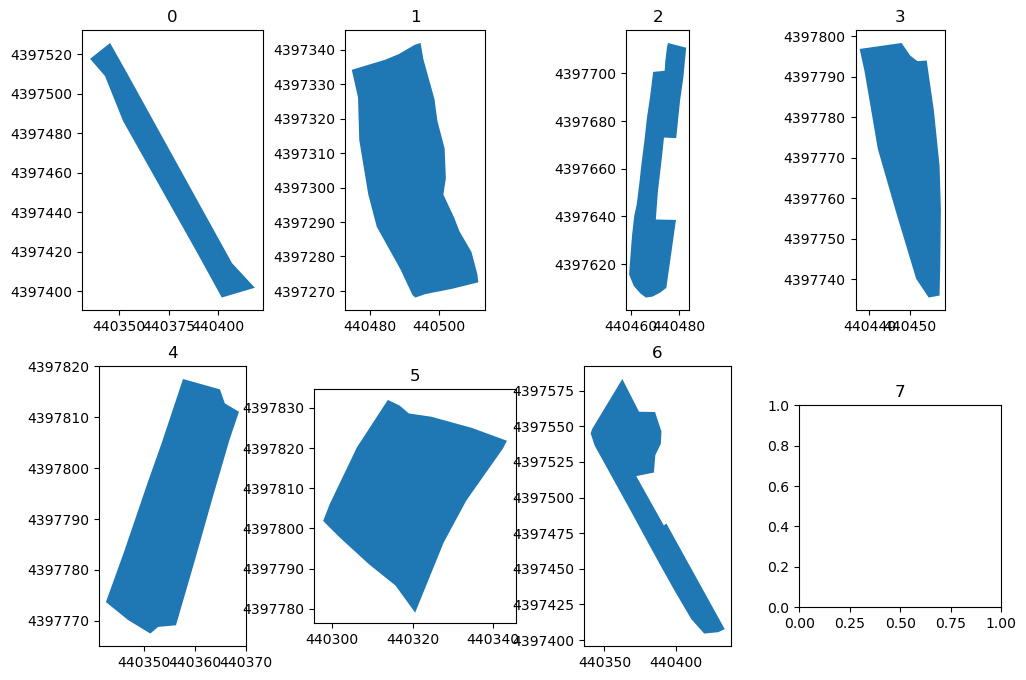

In [5]:
fig, axes = plt.subplots(2, 4, figsize=(12, 8))
for i, ax in enumerate(axes.flatten()):
    all_df.iloc[i:i + 1].plot(ax=ax)
    ax.set_title(i)
    ax.ticklabel_format(useOffset=False, style='plain')

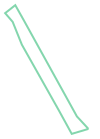

In [6]:
# 只读取 第一个
land_1 = all_df.iloc[0]
land_1.geometry.boundary

In [7]:
# 将地块的边界的形状映射为水平
# 1. 获取地块的边界
land_1_boundary = land_1.geometry.boundary
# 2. 获取边界的坐标
land_1_boundary_coords = land_1_boundary.coords
# 3. 获取边界的坐标的x,y值
land_1_boundary_coords_x = [i[0] for i in land_1_boundary_coords]
land_1_boundary_coords_y = [i[1] for i in land_1_boundary_coords]
# 4. 获取边界的坐标的x,y值的最大值和最小值
land_1_boundary_coords_x_max = max(land_1_boundary_coords_x)
land_1_boundary_coords_x_min = min(land_1_boundary_coords_x)
land_1_boundary_coords_y_max = max(land_1_boundary_coords_y)
land_1_boundary_coords_y_min = min(land_1_boundary_coords_y)
# 5. 获取边界的坐标的x,y值的最大值和最小值的差值
land_1_boundary_coords_x_diff = land_1_boundary_coords_x_max - land_1_boundary_coords_x_min
land_1_boundary_coords_y_diff = land_1_boundary_coords_y_max - land_1_boundary_coords_y_min
# 6. 判断差值的大小，如果x的差值大于y的差值，则说明地块的长边是水平的，否则是竖直的
if land_1_boundary_coords_x_diff > land_1_boundary_coords_y_diff:
    print('地块的长边是水平的')
else:
    print('地块的长边是竖直的')

地块的长边是竖直的


In [8]:
first_land = all_df.iloc[0]
first_land

NAME                                                        地2
LAYER                                        Unknown Area Type
perimeter                                             315.38 m
area                                            0.001833 sq km
geometry     POLYGON ((440418.557661284 4397401.723633145, ...
Name: 0, dtype: object

In [9]:
# try to rotate
from shapely.affinity import rotate

rotation_angle = 45
origin_point = (0, 0)
first_land

NAME                                                        地2
LAYER                                        Unknown Area Type
perimeter                                             315.38 m
area                                            0.001833 sq km
geometry     POLYGON ((440418.557661284 4397401.723633145, ...
Name: 0, dtype: object

## 将 shp 文件单独读取出来，并保存为一个全新的 数据的方法：
#### 首先保证数据已经单独取出来了 land_1 = all_df.iloc[0]，这里取出了第一个数据，不过，经过试验后发现，这个数据没有相应的坐标系等信息，这些数据存储在 all_df.crs 中
#### 于是下面就直接使用 geopandas.GeoDataFrame() 方法，将 land_1 转换为相应的 geopandas 格式，如果不加上后面的 crs，会无法显示图片

In [10]:
# 将 land_1 转换为相应的 geopandas 格式
land_1 = gpd.GeoDataFrame([land_1], crs=all_df.crs)

<Axes: >

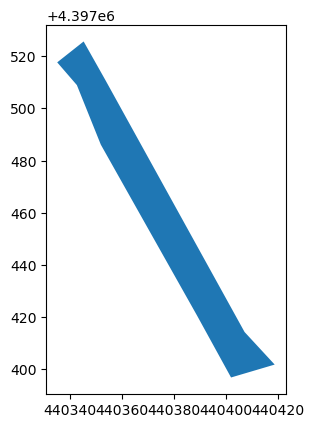

In [11]:
land_1.plot()

### 尝试找到当前田块的角度，并将其切换到水平，水平的边界一定是长边
#### 需要使用到 Polygon，手动写出：minimum_rotated_rectangle，就能够找到

In [12]:
import math

# 计算田块的几何对象的边界框（bounding box）
bounding_box = land_1.bounds

# 计算边界框的中心点
center_x = (bounding_box.minx + bounding_box.maxx) / 2
center_y = (bounding_box.miny + bounding_box.maxy) / 2

# 计算田块的最长边
lengths = bounding_box[['maxx', 'maxy']].subtract(bounding_box[['minx', 'miny']])
length = max(lengths.max())

# 找到最长边的起始点和结束点
start_x, start_y = center_x.values[0], center_y.values[0]
if lengths['maxx'].values[0] == length:
    end_x, end_y = bounding_box['maxx'].values[0], center_y.values[0]
else:
    end_x, end_y = center_x.values[0], bounding_box['maxy'].values[0]

# 计算角度
dx = end_x - start_x
dy = end_y - start_y
angle = math.degrees(math.atan2(dy, dx))
if angle < 0:
    angle += 360

print("田块的角度：", angle)

田块的角度： 90.0


In [13]:
print(center_x, "\n", center_y)
print(land_1.centroid)

0    440376.848171
dtype: float64 
 0    4.397461e+06
dtype: float64
0    POINT (440375.480 4397458.341)
dtype: geometry


<Axes: >

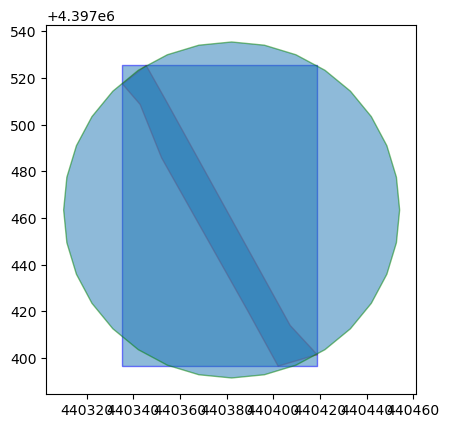

In [14]:
# 计算最小外包矩形
MABR = land_1.envelope
mabr2 = land_1.minimum_bounding_circle()
fig, ax = plt.subplots()
land_1.plot(ax=ax, alpha=0.5, edgecolor='r')
MABR.plot(ax=ax, alpha=0.5, edgecolor='b')
mabr2.plot(ax=ax, alpha=0.5, edgecolor='g')

In [15]:
land_1_polygon = land_1.geometry[0]
type(land_1_polygon)

shapely.geometry.polygon.Polygon

In [16]:
mabr = land_1_polygon.minimum_rotated_rectangle
mabr_bouding_box = mabr.boundary

/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/constructive.py:1000: RuntimeWarning: invalid value encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)


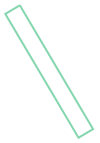

In [17]:
mabr_bouding_box

In [18]:
from shapely.geometry import Polygon, LineString
# 找到长边
longest_edge = None
max_length = -1
# 寻找最长边
for i in range(len(mabr.exterior.coords) - 1):
    p1 = mabr.exterior.coords[i]
    p2 = mabr.exterior.coords[i + 1]
    length = LineString([p1, p2]).length
    if length > max_length:
        max_length = length
        longest_edge = LineString([p1, p2])

In [19]:
# 计算角度
angle = math.degrees(math.atan2(longest_edge.coords[1][1] - longest_edge.coords[0][1],
                                longest_edge.coords[1][0] - longest_edge.coords[0][0]))
angle

-59.40616989768493

In [20]:
# 旋转，成功！
rotated_polygon = land_1.rotate(-angle, origin='centroid')

<Axes: >

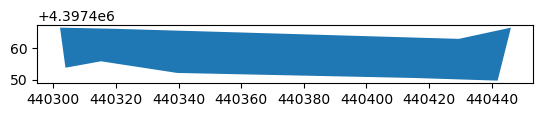

In [21]:
rotated_polygon.plot()

In [22]:
from CPP_Planner import CPP_Planner_Kit

<Axes: >

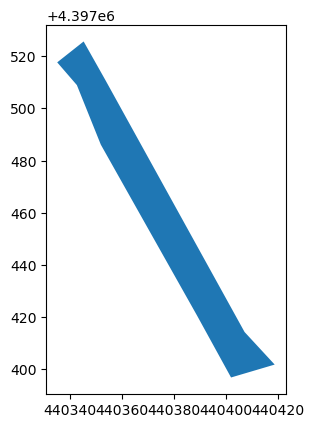

In [23]:
single = CPP_Planner_Kit.get_single_shp(all_df, 0)
single.plot()

In [24]:
angle = CPP_Planner_Kit.get_land_MABR_angle(single)
angle

AttributeError: 'GeoDataFrame' object has no attribute 'minimum_rotated_rectangle'

In [36]:
import datetime
datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

'2023_06_13_23_58_51'